C:\Users\user\AppData\Local\Temp\ipykernel_25644\4250143902.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Optimal candidate: [100.   66.7   8.   98.8]
Optimal candidate details:
ps                    100.0
s_job_avg              66.7
rate_avg                8.0
star_avg               98.8
edu_institute    군산용접산업설비학원
Name: 449, dtype: object
Skyline candidates details:
         ps  s_job_avg  rate_avg  star_avg      edu_institute
449   100.0       66.7      8.00      98.8         군산용접산업설비학원
2174  100.0       64.0      8.00      98.7       종로창신요양보호사교육원
2827  100.0       64.0      8.00      97.4         황성요양보호사교육원
1738  100.0       65.5      8.00      96.1            여수중장비학원
1219  100.0       64.0      8.00      94.6       사랑드림요양보호사교육원
939   100.0       50.0      9.00     100.0  맘보바리스타제과제빵학원 홍대지점
150   100.0      100.0      7.00      94.2       4세대아카데미컴퓨터학원
660   100.0       79.2      7.00      96.4       대경캐드디자인컴퓨터학원
1796  100.0       75.8      7.33      92.6         예우전산세무회계학원
310   100.0       50.0      8.00     100.0        경남UAV시스텍연구소
Worst candidates details:
        ps  s_job_avg  rate

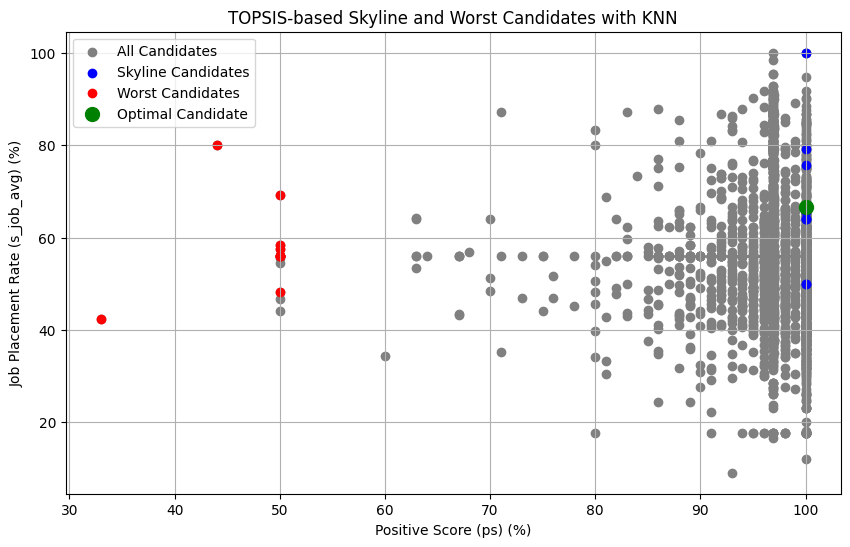

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import pymysql

# 데이터베이스 설정
# db_config = {
#     'host': '',
#     'port': ,
#     'user': '',
#     'password': '',
#     'database': '',
# }

# MySQL 데이터베이스에서 데이터 가져오기
def fetch_data_from_db():
    try:
        connection = pymysql.connect(**db_config)
        query = "SELECT ps, s_job_avg, rate_avg, star_avg, edu_institute FROM skyline.senti_ed"
        df = pd.read_sql(query, connection)
        connection.close()
        return df
    except Exception as e:
        print(f"Error fetching data from database: {e}")
        return pd.DataFrame()

# TOPSIS 알고리즘 구현
def topsis(df, weights):
    # Step 1: Normalize the data
    scaler = MinMaxScaler()
    normalized_df = scaler.fit_transform(df.iloc[:, :-1])  # edu_institute 제외

    # Step 2: Apply weights
    weighted_df = normalized_df * weights

    # Step 3: Identify ideal and anti-ideal solutions
    ideal_solution = np.max(weighted_df, axis=0)
    anti_ideal_solution = np.min(weighted_df, axis=0)

    # Step 4: Calculate the distance to the ideal and anti-ideal solutions
    distance_to_ideal = np.sqrt(np.sum((weighted_df - ideal_solution) ** 2, axis=1))
    distance_to_anti_ideal = np.sqrt(np.sum((weighted_df - anti_ideal_solution) ** 2, axis=1))

    # Step 5: Calculate the similarity to the ideal solution
    similarity_to_ideal = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)

    # Step 6: Rank the solutions
    ranking = np.argsort(similarity_to_ideal)[::-1]
    return ranking, similarity_to_ideal

# 데이터 전처리
df = fetch_data_from_db()
if df.empty:
    print("No data fetched from the database.")
else:
    # DataFrame을 numpy 배열로 변환
    candidates = df[['ps', 's_job_avg', 'rate_avg', 'star_avg']].values  # 4개 지표 사용

    # 가중치 설정 (예: 각 지표의 가중치)
    weights = np.array([0.5, 0.1, 0.2, 0.4])  # ps는 값이 높을수록 좋으므로 가중치를 양수로 설정

    # TOPSIS 알고리즘 적용
    ranking, similarity_to_ideal = topsis(df, weights)

    # 스카이라인 후보 선택
    skyline_candidates = candidates[ranking[:10]]  # 예: 상위 10개 후보 선택
    worst_candidates = candidates[ranking[-10:]]  # 예: 하위 10개 후보 선택
    skyline_indices = ranking[:10]
    worst_indices = ranking[-10:]

    # 데이터 확인
    
    if len(skyline_candidates) < 3:
        print("Not enough skyline candidates to perform KNN.")
    else:
        # K-최근접 이웃 알고리즘을 사용하여 최적의 후보 선택
        def apply_knn(data, k=3):
            """K-최근접 이웃 알고리즘을 사용하여 최적의 후보 선택."""
            data = np.array(data)
            if data.ndim == 1:
                data = data.reshape(-1, 2)
            if len(data) >= k:
                nbrs = NearestNeighbors(n_neighbors=k).fit(data)
                distances, indices = nbrs.kneighbors(data)
                return distances, indices
            else:
                print(f"Error: Not enough data points ({len(data)}) to find {k} neighbors.")
                return None, None

        k = 3
        distances, indices = apply_knn(skyline_candidates, k)

        if distances is not None and indices is not None:
            # 최적의 후보 데이터 출력
            optimal_candidate_idx = indices[0][0]
            optimal_candidate = skyline_candidates[optimal_candidate_idx]
            print(f"Optimal candidate: {optimal_candidate}")

            # 최적의 후보와 스카이라인 후보 데이터 출력
            optimal_candidate_df = df.iloc[skyline_indices[optimal_candidate_idx]]
            skyline_candidates_df = df.iloc[skyline_indices]
            worst_candidates_df = df.iloc[worst_indices]

            # 각 점에 해당하는 데이터를 출력
            print(f"Optimal candidate details:\n{optimal_candidate_df}")
            print(f"Skyline candidates details:\n{skyline_candidates_df}")
            print(f"Worst candidates details:\n{worst_candidates_df}")

            # 시각화 (주요 지표 2개 사용)
            plt.figure(figsize=(10, 6))
            plt.scatter(df['ps'], df['s_job_avg'], c='gray', label='All Candidates')
            plt.scatter(skyline_candidates[:, 0], skyline_candidates[:, 1], c='blue', label='Skyline Candidates')
            plt.scatter(worst_candidates[:, 0], worst_candidates[:, 1], c='red', label='Worst Candidates')
            plt.scatter(optimal_candidate[0], optimal_candidate[1], c='green', label='Optimal Candidate', s=100)

            plt.xlabel('Positive Score (ps) (%)')
            plt.ylabel('Job Placement Rate (s_job_avg) (%)')
            plt.title('TOPSIS-based Skyline and Worst Candidates with KNN')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("Error in applying KNN. Cannot visualize results.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import json
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as fm
import os

# JSON 파일 읽기
with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)

# 정규화할 열 리스트 (문자열 열 제외)
numeric_columns = ['final_weighted_score', 'star', 'emp']

# 데이터 타입 변환 (숫자형으로 변환)
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 결측값 확인 및 처리 (필요한 경우)
df = df.dropna(subset=numeric_columns)

# TOPSIS 알고리즘 구현
def topsis(df, weights):
    # Step 1: Normalize the data
    scaler = MinMaxScaler()
    normalized_df = scaler.fit_transform(df[numeric_columns])  # 정규화할 열만 선택

    # Step 2: Apply weights
    weighted_df = normalized_df * weights

    # Step 3: Identify ideal and anti-ideal solutions
    ideal_solution = np.max(weighted_df, axis=0)
    anti_ideal_solution = np.min(weighted_df, axis=0)

    # Step 4: Calculate the distance to the ideal and anti-ideal solutions
    distance_to_ideal = np.sqrt(np.sum((weighted_df - ideal_solution) ** 2, axis=1))
    distance_to_anti_ideal = np.sqrt(np.sum((weighted_df - anti_ideal_solution) ** 2, axis=1))

    # Step 5: Calculate the similarity to the ideal solution
    similarity_to_ideal = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)

    # Step 6: Rank the solutions
    ranking = np.argsort(similarity_to_ideal)[::-1]
    return ranking, similarity_to_ideal

# 데이터가 비어 있는지 확인
if df.empty:
    print("No data fetched from the database.")
else:
    # DataFrame을 numpy 배열로 변환하여 후보자 데이터 준비
    candidates = df[numeric_columns].values

    # 가중치 설정 (예: 각 지표의 가중치)
    weights = np.array([0.4, 0.3, 0.3])

    # TOPSIS 알고리즘 적용
    ranking, similarity_to_ideal = topsis(df, weights)

    # 베스트 후보와 워스트 후보 선택
    best_candidates = candidates[ranking[:10]]  # 예: 상위 10개 후보 선택
    worst_candidates = candidates[ranking[-10:]]  # 예: 하위 10개 후보 선택
    best_indices = ranking[:10]
    worst_indices = ranking[-10:]

    # 데이터 확인
    if len(best_candidates) < 3:
        print("Not enough best candidates to perform KNN.")
    else:
        # K-최근접 이웃 알고리즘을 사용하여 최적의 후보 선택
        def apply_knn(data, k=3):
            """K-최근접 이웃 알고리즘을 사용하여 최적의 후보 선택."""
            data = np.array(data)
            if data.ndim == 1:
                data = data.reshape(-1, 2)
            if len(data) >= k:
                nbrs = NearestNeighbors(n_neighbors=k).fit(data)
                distances, indices = nbrs.kneighbors(data)
                return distances, indices
            else:
                print(f"Error: Not enough data points ({len(data)}) to find {k} neighbors.")
                return None, None

        k = 3
        distances, indices = apply_knn(best_candidates, k)

        if distances is not None and indices is not None:
            # 최적의 후보 데이터 출력
            prime_candidate_idx = indices[0][0]
            prime_candidate = best_candidates[prime_candidate_idx]
            print(f"Prime candidate: {prime_candidate}")

            # 최적의 후보가 베스트 후보에 포함되지 않도록 제거
            best_candidates = np.delete(best_candidates, prime_candidate_idx, axis=0)
            best_indices = np.delete(best_indices, prime_candidate_idx)

            # 순위를 매긴 최종 결과를 준비
            ranked_best_candidates = [{"rank": i+2, **df.iloc[best_indices[i]].to_dict()} for i in range(len(best_candidates))]
            ranked_worst_candidates = [{"rank": len(worst_candidates) - i, **df.iloc[worst_indices[i]].to_dict()} for i in range(len(worst_candidates))]

            # 최적의 후보와 베스트 후보 데이터 출력
            prime_candidate_df = df.iloc[ranking[prime_candidate_idx]]
            best_candidates_df = df.iloc[best_indices]
            worst_candidates_df = df.iloc[worst_indices]

            # 각 점에 해당하는 데이터를 출력
            print(f"Prime candidate details:\n{prime_candidate_df}")
            print(f"Best candidates details:\n{best_candidates_df}")
            print(f"Worst candidates details:\n{worst_candidates_df}")

            # JSON으로 변환하여 저장
            result_data = {
                "prime_candidate": {"rank": 1, **prime_candidate_df.to_dict()},
                "ranked_best_candidates": ranked_best_candidates,
                "ranked_worst_candidates": ranked_worst_candidates
            }

            with open('topsis_result.json', 'w', encoding='utf-8') as f:
                json.dump(result_data, f, ensure_ascii=False, indent=4)

            # 결과를 CSV 파일로 저장
            prime_candidate_df.to_frame().T.to_csv('prime_candidate.csv', index=False, encoding='utf-8')
            best_candidates_df.to_csv('best_candidates.csv', index=False, encoding='utf-8')
            worst_candidates_df.to_csv('worst_candidates.csv', index=False, encoding='utf-8')

            # 폰트 파일 경로 설정
            font_location = os.path.abspath('C:/font/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf')

            # 폰트를 직접 로드하여 추가
            font_prop = fm.FontProperties(fname=font_location)

            # 폰트 이름 얻기
            font_name = font_prop.get_name()
            print(f"폰트다 뇬석아: {font_name}")  # 폰트 이름 출력하여 확인
            fm.fontManager.addfont(font_location)

            # matplotlib에 폰트 설정
            plt.rcParams['font.family'] = font_name

            # 시각화 (3차원 산점도)
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            # 베스트 후보 표시
            ax.scatter(best_candidates[:, 0], best_candidates[:, 1], best_candidates[:, 2], c='blue', marker='o', s=100, label='우수훈련기관')

            # 워스트 후보 표시
            ax.scatter(worst_candidates[:, 0], worst_candidates[:, 1], worst_candidates[:, 2], c='red', marker='o', s=100, label='위험훈련기관')

            # 최적의 후보 표시 (별 모양으로 표시, 크기 더 크게)
            ax.scatter(prime_candidate[0], prime_candidate[1], prime_candidate[2], c='green', marker='*', s=300, label='최적훈련기관')

            # 축 레이블과 제목 설정
            ax.set_xlabel('나침반 긍정지수')
            ax.set_ylabel('만족도')
            ax.set_zlabel('취업률')
            ax.set_title('TOPSIS-기반 순위')

            # 범례 추가
            ax.legend()

            # 그리드 추가
            ax.grid(True)

            # 그래프 출력
            plt.show()
        else:
            print("Error in applying KNN. Cannot visualize results.")
